In [7]:
import tensorflow as tf
from skimage import io
import numpy as np
import requests
from io import BytesIO
import matplotlib.pyplot as plt
from PIL import Image
import onnx
from onnx_tf.backend import prepare
from PIL import Image
import os
import time
from PIL import Image
import numpy as np
import tensorflow as tf
# import tensorflow_hub as hub
import matplotlib.pyplot as plt
os.environ["TFHUB_DOWNLOAD_PROGRESS"] = "True"

import torch
from torch.nn import functional as F
import cv2

In [2]:
onnx_path = "RealESRGAN_x4plus.onnx"
tf_path = "tf_model/"

onnx_model = onnx.load(onnx_path)  # load onnx model
onnx.checker.check_model(onnx_model)

tf_rep = prepare(onnx_model)
tf_rep.export_graph(tf_path)

2022-10-06 15:21:31.586115: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-10-06 15:21:31.586327: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: pratik-rizzle
2022-10-06 15:21:31.586332: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: pratik-rizzle
2022-10-06 15:21:31.586497: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.141.3
2022-10-06 15:21:31.586526: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.141.3
2022-10-06 15:21:31.586531: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.141.3
2022-10-06 15:21:31.587551: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performanc

INFO:tensorflow:Assets written to: tf_model/assets


INFO:tensorflow:Assets written to: tf_model/assets


In [22]:
tf_path = "tf_model/"
model = tf.saved_model.load(tf_path)
print(list(model.signatures.keys()))  # ["serving_default"]

infer = model.signatures["serving_default"]
print(infer.structured_outputs)
# infer.inputs

['serving_default']
{'output0': TensorSpec(shape=(1, 3, 768, 768), dtype=tf.float32, name='output0')}


In [9]:
# def preprocess_image(image_path):
#   """ Loads image from path and preprocesses to make it model ready
#       Args:
#         image_path: Path to the image file
#   """
#   hr_image = tf.image.decode_image(tf.io.read_file(image_path))
#   # If PNG, remove the alpha channel. The model only supports
#   # images with 3 color channels.
#   if hr_image.shape[-1] == 4:
#     hr_image = hr_image[...,:-1]
#   hr_size = (tf.convert_to_tensor(hr_image.shape[:-1]) // 4) * 4
#   hr_image = tf.image.crop_to_bounding_box(hr_image, 0, 0, hr_size[0], hr_size[1])
#   hr_image = tf.cast(hr_image, tf.float32)
#   return tf.expand_dims(hr_image, 0)

def preprocess_image(img_path, pre_pad=10, mod_scale=4):
    img = cv2.imread(img_path)
    h_input, w_input = img.shape[0:2]
    # img: numpy
    img = img.astype(np.float32)
    if np.max(img) > 256:  # 16-bit image
        max_range = 65535
        print('\tInput is a 16-bit image')
    else:
        max_range = 255
    img = img / max_range
    if len(img.shape) == 2:  # gray image
        img_mode = 'L'
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    elif img.shape[2] == 4:  # RGBA image with alpha channel
        img_mode = 'RGBA'
        alpha = img[:, :, 3]
        img = img[:, :, 0:3]
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if alpha_upsampler == 'realesrgan':
            alpha = cv2.cvtColor(alpha, cv2.COLOR_GRAY2RGB)
    else:
        img_mode = 'RGB'
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = torch.from_numpy(np.transpose(img, (2, 0, 1))).float()
    img = img.unsqueeze(0).to("cpu")
    img = F.pad(img, (0, pre_pad, 0, pre_pad), 'reflect')
    
    mod_pad_h, mod_pad_w = 0, 0
    _, _, h, w = img.size()
    if (h % mod_scale != 0):
        mod_pad_h = (mod_scale - h % mod_scale)
    if (w % mod_scale != 0):
        mod_pad_w = (mod_scale - w % mod_scale)
    img = F.pad(img, (0, mod_pad_w, 0, mod_pad_h), 'reflect')
    
    return img, mod_pad_h, mod_pad_w


def save_image(image, filename):
  """
    Saves unscaled Tensor Images.
    Args:
      image: 3D image tensor. [height, width, channels]
      filename: Name of the file to save.
  """
  if not isinstance(image, Image.Image):
    image = tf.clip_by_value(image, 0, 255)
    image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  image.save("%s.jpg" % filename)
  print("Saved as %s.jpg" % filename)

In [5]:
%matplotlib inline
def plot_image(image, title=""):
  """
    Plots images from image tensors.
    Args:
      image: 3D image tensor. [height, width, channels].
      title: Title to display in the plot.
  """
  image = np.asarray(image)
  image = tf.clip_by_value(image, 0, 255)
  image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  plt.imshow(image)
  plt.axis("off")
  plt.title(title)

In [12]:
IMAGE_PATH = "/opt/rizzle/repos/experiments/super_resolution/Real-ESRGAN/inputs/0014.jpg"
hr_image, _, _ = preprocess_image(IMAGE_PATH)
# print(hr_image.shape)
hr_np = hr_image.numpy()
print(hr_np.shape)

(1, 3, 192, 192)


Saved as Original Image.jpg


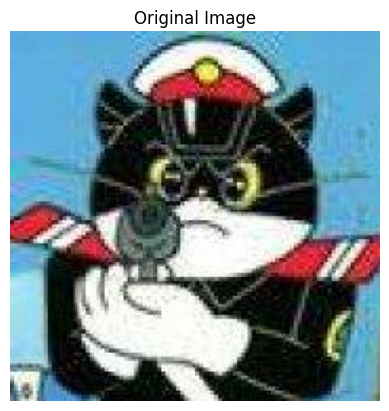

In [10]:
# Plotting Original Resolution image
plot_image(tf.squeeze(hr_image), title="Original Image")
save_image(tf.squeeze(hr_image), filename="Original Image")

In [23]:
start = time.time()
# x = tf.convert_to_tensor(hr_np, dtype=tf.float32, name="input0")
fake_image = infer(hr_np)
print("Time Taken: %f" % (time.time() - start))
fake_image = tf.squeeze(fake_image["output0"])


ValueError: Attempt to convert a value ({'output0': <tf.Tensor: shape=(1, 3, 768, 768), dtype=float32, numpy=
array([[[[0.43759447, 0.37877008, 0.38632935, ..., 0.37264627,
          0.38420588, 0.4191633 ],
         [0.3805585 , 0.3734433 , 0.3789748 , ..., 0.3743907 ,
          0.38031864, 0.3761736 ],
         [0.37222448, 0.37557167, 0.37027675, ..., 0.37244433,
          0.3690119 , 0.3690879 ],
         ...,
         [0.11079675, 0.10701899, 0.10245413, ..., 0.44375283,
          0.44879243, 0.44437787],
         [0.12454802, 0.13015872, 0.10062083, ..., 0.43565536,
          0.43970054, 0.43952662],
         [0.13078961, 0.10575811, 0.08617266, ..., 0.43712124,
          0.45139745, 0.48992738]],

        [[0.66880494, 0.6792016 , 0.6745601 , ..., 0.66805446,
          0.6755157 , 0.65488684],
         [0.67080605, 0.6743623 , 0.67875445, ..., 0.67013794,
          0.6734073 , 0.66640097],
         [0.672313  , 0.66898876, 0.6671557 , ..., 0.66957235,
          0.6687482 , 0.6794947 ],
         ...,
         [0.22151586, 0.22256112, 0.20890105, ..., 0.64989   ,
          0.6551269 , 0.646507  ],
         [0.22019115, 0.24133915, 0.22306845, ..., 0.6485331 ,
          0.6578929 , 0.66022086],
         [0.20557994, 0.18385601, 0.17750281, ..., 0.6474376 ,
          0.669859  , 0.656484  ]],

        [[0.86971265, 0.8733742 , 0.8747058 , ..., 0.86412036,
          0.882128  , 0.8622266 ],
         [0.8713451 , 0.8722377 , 0.88175607, ..., 0.8591765 ,
          0.86554796, 0.8534896 ],
         [0.879917  , 0.87262475, 0.87765986, ..., 0.86226904,
          0.8558828 , 0.8469435 ],
         ...,
         [0.23530419, 0.23571034, 0.24707155, ..., 0.776774  ,
          0.7797685 , 0.77133685],
         [0.23150939, 0.26288852, 0.25978386, ..., 0.77614313,
          0.7898063 , 0.79955417],
         [0.2344782 , 0.23674479, 0.22530323, ..., 0.78185844,
          0.7859979 , 0.7170163 ]]]], dtype=float32)>}) with an unsupported type (<class 'dict'>) to a Tensor.

In [ ]:
# Plotting Super Resolution Image
plot_image(tf.squeeze(fake_image), title="Super Resolution")
save_image(tf.squeeze(fake_image), filename="Super Resolution")